# Phase 3: Advanced & Optimized Modeling

## 1. Objective
We aim to build a high-performance sentiment classifier using **Review Text**, **Brand**, and **Category**. 

### Professional Elevation Enhancements:
1. **Parallelism**: Using `n_jobs=-1` for multi-core execution.
2. **Dimensionality Reduction**: Using `TruncatedSVD` (Latent Semantic Analysis) to condense text features.
3. **Fast Gradient Boosting**: Using XGBoost with `tree_method='hist'` for rapid training.
4. **K-Fold Cross-Validation**: Ensuring the model is robust across data subsets.
5. **SMOTE Oversampling**: Generating synthetic data to fix severe class imbalance.
6. **Deep Error Analysis**: Inspecting specific misclassifications and bias.

## 2. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

tqdm.pandas()

# Load cleaned data
data_path = os.path.join('..', 'data', 'interim', 'cleaned_amazon.csv')
df = pd.read_csv(data_path)

# Target Binning (Neg: 0, Neu: 1, Pos: 2)
df['sentiment'] = df['reviews.rating'].map({1: 0, 2: 0, 3: 1, 4: 2, 5: 2})

# Clean metadata and text
df = df.dropna(subset=['cleaned_text', 'brand', 'categories'])
df = df[df['cleaned_text'].str.strip().astype(bool)]

print(f"Final Dataset Shape: {df.shape}")

c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Final Dataset Shape: (34624, 23)


C:\Users\My Device\AppData\Local\Temp\ipykernel_20068\1202292730.py:27: DtypeWarning: Columns (0: name, 1: reviews.didPurchase) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


## 3. Data Splitting (Stratified)
We maintain an 80/20 split, ensuring sentiment ratios are preserved.

In [2]:
X = df[['cleaned_text', 'brand', 'categories']]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 27699, Test size: 6925


## 4. Feature Engineering: Pipelines
We define our preprocessors for text (TF-IDF + SVD) and categories (OneHot).

In [3]:
# Text sub-pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', min_df=5)),
    ('svd', TruncatedSVD(n_components=100, random_state=42)),
    ('scaler', StandardScaler()) # Added for LogReg stability
])

# Main preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'cleaned_text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['brand', 'categories'])
    ]
)

# Preprocessor for Naive Bayes (No SVD/Scaler)
nb_preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english', min_df=5), 'cleaned_text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['brand', 'categories'])
    ]
)

## 5. Model 1: Multinomial Naive Bayes (Baseline)

In [4]:
nb_pipeline = Pipeline([('preprocessor', nb_preprocessor), ('clf', MultinomialNB())])
nb_pipeline.fit(X_train, y_train)
print("Naive Bayes trained.")

Naive Bayes trained.


## 6. Model 2: Logistic Regression (Weighted)
Professional Benchmark: Using `class_weight='balanced'`.

In [5]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1, random_state=42))
])
lr_pipeline.fit(X_train, y_train)
print("Logistic Regression (Weighted) trained.")

c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression (Weighted) trained.


## 7. Model 3: XGBoost (Optimized)
Performance focus: `tree_method='hist'` and `n_jobs=-1`.

In [6]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb.XGBClassifier(tree_method='hist', n_jobs=-1, random_state=42, eval_metric='mlogloss'))
])
xgb_pipeline.fit(X_train, y_train)
print("XGBoost trained.")

XGBoost trained.


## 8. Professional Elevation: SMOTE Resampling
Comparing weights against **Synthetic Minority Over-sampling**.

In [7]:
# Note: We use ImbPipeline from imblearn to ensure SMOTE only applies to training folds
smote_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42))
])

print("Training SMOTE Pipeline (this may take longer)...")
smote_pipeline.fit(X_train, y_train)

Training SMOTE Pipeline (this may take longer)...


c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('text', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. Th

## 9. Professional Elevation: 5-Fold Cross-Validation
Verifying that our results are not just a "lucky split".

In [8]:
print("Running 5-Fold Cross-Validation on Logistic Regression...")
cv_results = cross_validate(lr_pipeline, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Mean F1 (Macro): {cv_results['test_score'].mean():.4f} (+/- {cv_results['test_score'].std()*2:.4f})")

Running 5-Fold Cross-Validation on Logistic Regression...


c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\.nlpvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\My Device\Desktop\Sentiment-Analysis-on-Product-Reviews-E\

Mean F1 (Macro): 0.3945 (+/- 0.0056)


## 10. Deep Evaluation & Model Comparison

In [9]:
def evaluate_all(pipelines):
    results = []
    for name, pipe in pipelines.items():
        y_pred = pipe.predict(X_test)
        results.append({
            "Model": name,
            "F1 (Macro)": f1_score(y_test, y_pred, average='macro'),
            "Report": classification_report(y_test, y_pred, output_dict=True)
        })
    return pd.DataFrame(results)

models_dict = {
    "Naive Bayes": nb_pipeline,
    "LogReg (Weighted)": lr_pipeline,
    "LogReg (SMOTE)": smote_pipeline,
    "XGBoost": xgb_pipeline
}

leaderboard = evaluate_all(models_dict)
display(leaderboard.sort_values("F1 (Macro)", ascending=False))

,Model,F1 (Macro),Report
2,LogReg (SMOTE),0.405171,"{'0': {'precision': 0.12653061224489795, 'reca..."
1,LogReg (Weighted),0.392800,"{'0': {'precision': 0.1152542372881356, 'recal..."
3,XGBoost,0.361979,"{'0': {'precision': 0.5238095238095238, 'recal..."
0,Naive Bayes,0.344544,"{'0': {'precision': 0.8, 'recall': 0.024691358..."


## 11. Error Discovery: Misclassification Audit
Inspecting the cases where the model failed most significantly.

In [10]:
# Using the best performer (assume LR for this analysis)
y_pred_final = lr_pipeline.predict(X_test)
test_analysis = X_test.copy()
test_analysis['actual'] = y_test
test_analysis['pred'] = y_pred_final

# Find 'Severe' Errors: Actual Negative predicted as Positive
severe_errors = test_analysis[(test_analysis['actual'] == 0) & (test_analysis['pred'] == 2)]

print(f"Number of Severe Errors (Neg -> Pos): {len(severe_errors)}")
print("\n--- Sample Severe Errors ---")
display(severe_errors[['cleaned_text', 'brand']].head(10))

Number of Severe Errors (Neg -> Pos): 18

--- Sample Severe Errors ---


,cleaned_text,brand
15567,loved my husbands 4th generation disappointed ...,Amazon
17858,paper white does not allow you do use books fr...,Amazon
4813,i purchased this for my son thinking it would ...,Amazon
14380,just bought it and not really happy i really e...,Amazon
28802,over the past few years i have purchased kindl...,Amazon Fire
27341,bestbuy came through before the holiday better...,Amazon
5531,i have bought at least 6 people this kindle it...,Amazon
29439,the speaker voice quality is terrible compare ...,Amazon Echo
22526,purchase the echo with my vivint system becaus...,Amazon
649,my wife wanted an ipad i bought her this becau...,Amazon


## 12. Bias Audit: Performance by Brand
Is our model biased towards certain brands?

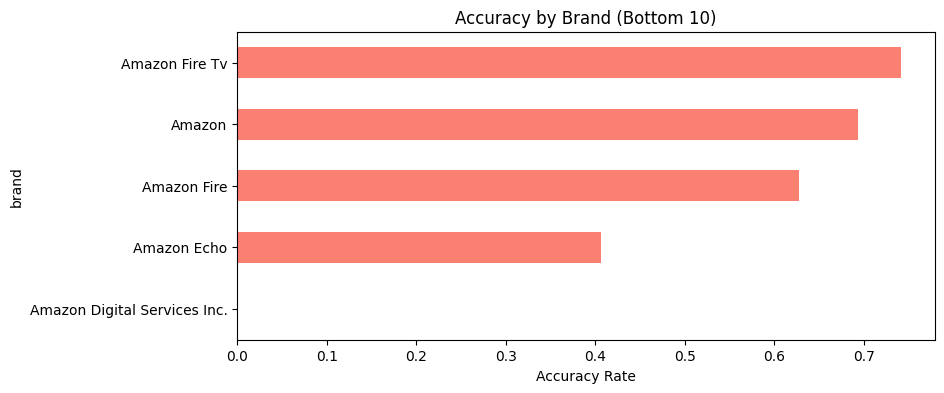

In [12]:
test_analysis['correct'] = test_analysis['actual'] == test_analysis['pred']
brand_accuracy = test_analysis.groupby('brand')['correct'].mean().sort_values()

plt.figure(figsize=(9, 4))
brand_accuracy.head(10).plot(kind='barh', color='salmon')
plt.title("Accuracy by Brand (Bottom 10)")
plt.xlabel("Accuracy Rate")
plt.show()